In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import math
import PyUltraLight as PyUltraLight
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from IPython.core.display import clear_output, display
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Set Axion Mass

In [2]:
axion_mass = 1e-22 *1.783e-36 #kg

# Set Simulation Parameters

In [3]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()

# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units

# Set box size and resolution
length = 10 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.
resol= 256 # It is recommended to check the upper bound on soliton mass for a given box size and resolution
duration = 0.15 # 1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units
start_time = 0.0 # Should be given in the same units as duration. 
central_mass = 1. # Give this parameter in the same units as the soliton mass unit. i.e. units must match with s_mass_unit

#Data to save
save_rho = False # Saves density data for entire 3D simulation grid
save_psi = False # Saves full complex field data for entire 3D simulation grid
save_plane = True # Saves density data for plane z = 0
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists
save_line = True # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 

#Formats to save
hdf5 = False
npz = False
npy = True

step_factor = 1. # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 
save_number = 60    # Choose number of 'frames' to save. Note that, depending on resolution, this could require significant disk space.
save_path = 'Vanilla'  # Set output directory

save_options = [save_rho,save_psi,save_plane,save_energies,save_line]

# Set Initial Conditions:

In [4]:
m = 8 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
r = 2 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5
#v = np.sqrt(central_mass/r)

#Soliton parameters are mass, position, velocity and phase (radians)
soliton1 = [6, [r,r,0], [-20,10,0], 0]
#soliton2 = [6, [-r,-r,0], [20,-10,0], 0]

solitons = []  


# Run:

In [5]:
PyUltraLight.evolve(central_mass, num_threads, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons, start_time)



Complete.


# Visualisations:

<ipython-input-7-61e102590dfa>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().get_xaxis().set_ticks([])


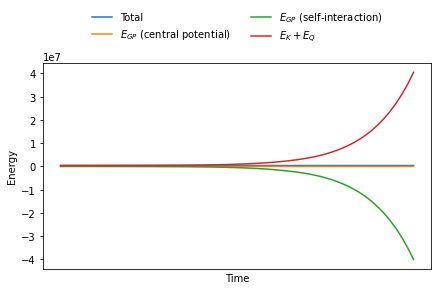

In [7]:
output_animated = 2
# 0 for all contours plotted on a single graph (useful when total number of saves is <=10), 
# 1 for an animation of plane of density contours (useful when number of saves is large, may take some time),
# 2 for plot of energies over time, 
# 3 for animation of line along axis of symmetry (useful for studying interference patterns).
save_plots = 0
# 0 to display in this window without saving,
# 1 to save as well (will save in 'Visualisations' directory).

#######################################################################

with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
  ts = timestamp.read()

loc = save_path + '/' + ts

if output_animated == 2:

    egylist = np.load('{}{}'.format(loc, '/egylist.npy')).tolist()
    egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy')).tolist()
    egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy')).tolist()
    ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy')).tolist()
    masslist = np.load('{}{}'.format(loc, '/masslist.npy')).tolist()
    plt.plot(egylist,label='Total')
    plt.plot(egpcmlist,label='$E_{GP}$ (central potential)')
    plt.plot(egpsilist,label='$E_{GP}$ (self-interaction)')
    plt.plot(ekandqlist,label='$E_{K}+E_{Q}$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)
    plt.axes().get_xaxis().set_ticks([])
    plt.ylabel('Energy')
    plt.xlabel('Time')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if save_plots == 1:
        plt.savefig('./Visualisations/energy_diagram.eps', format='eps', dpi=1000)
        plt.savefig('./Visualisations/energy_diagram.jpg', format='jpg', dpi=1000)
    plt.show()

if output_animated == 0:
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    plt.figure(figsize=(20,10))
    for x in np.arange(0,save_number+1,1):
        if x == 0:
            plt.contour(np.load('{}{}{}{}'.format(loc, '/plane_#',x,'.npy')),colors='k')
        if x in np.arange(1,save_number+1,1):
            plt.contour(np.load('{}{}{}{}'.format(loc, '/plane_#',x,'.npy')))
            plt.axes().set_aspect('equal')
            plt.axes().get_xaxis().set_ticks([])
            plt.axes().get_yaxis().set_ticks([])
    if save_plots == 1:
        plt.savefig('{}'.format('./Visualisations/Static_contours.eps'), format='eps', dpi=1000)
        plt.savefig('{}'.format('./Visualisations/Static_contours.jpg'), format='jpg', dpi=1000)
    plt.show()

if output_animated in (1,3):        

    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    fig,ax = plt.subplots(figsize=(20, 10))
    plt.axes().set_aspect('equal')
    
    data = []
    
    for x in np.arange(0,save_number+1,1):
        if output_animated == 1:
            data.append(np.load('{}{}{}{}'.format(loc, '/plane_#', x, '.npy')))
        if output_animated == 3:
            data.append(np.load('{}{}{}{}'.format(loc, '/line_#', x, '.npy')))
    if output_animated == 3:
        m = []
        for i in np.arange(0,save_number+1,1):
            m.append(max(data[i]))
            lim = max(m)
            

    planemax = np.max(data)
    planemin = np.min(data)

            
    def animate(i):
        plt.clf()
        if output_animated == 1:
            plot = plt.imshow(data[i],vmin = planemin, vmax = planemax)
            plt.axes().set_aspect('equal')
            plt.axes().get_xaxis().set_ticks([])
            plt.axes().get_yaxis().set_ticks([])
            plt.title('Mass Density - Plane')
        if output_animated == 3:
            plt.clf()
            plot = plt.plot(data[i])    
            plt.title('Mass Density - Line')
            plt.axes().set_ylim(0,lim)

    Writer = matplotlib.animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='PyUltraLight'), bitrate=1800)
            
    interval = 0.15 #in seconds
    ani = matplotlib.animation.FuncAnimation(fig,animate,save_number+1,interval=interval*1e+3,blit=False)
    if save_plots == 1:
        if output_animated == 1:
            ani.save('./plane_animation.mp4', writer=writer)
        if output_animated == 1:
            ani.save('./line_animation.mp4', writer=writer)

            
    from IPython.display import HTML
    animated_plot = HTML(ani.to_jshtml())

    if save_plots == 1:  
        save_html = animated_plot.data
        if output_animated == 1:
            with open('./plane_animation.html', 'w') as f:
                f.write(save_html)
        if output_animated == 3:
            with open('./line_animation.html', 'w') as f:
                f.write(save_html)
    display(animated_plot) 
    plt.close()     